# Least-relocation LSCP model

Author: Huanfa Chen, Rongbo Xu

In [1]:
# %time
import numpy
import geopandas 
import pandas
import pulp
from shapely.geometry import Point
import matplotlib.pyplot as plt
# from google.colab import files
import spopt
from spopt.locate.coverage import LSCP
import time

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Import data

In [2]:
# the service distance in metres (equal to 10 miles)
service_dist = 16093.4
# the distance greater than service distance
great_dist = 20000

In [3]:
# import distance data
# the distance between existing sites and covered MSOAs
df_distance_existing_sites_covered_MSOA = pandas.read_csv('../Data/distance_df_existing_sites_MSOA.csv')

# the distance between potential sites and uncovered MSOAs
df_distance_potential_sites_all_MSOA = pandas.read_csv('../Data/distance_df_potential_sites_all_MSOA.csv')

In [4]:
df_distance_existing_sites_covered_MSOA.head(10)

,Unnamed: 0,origin_id,dest_id,distance
0,122,E02002536,E122,6712.7
1,127,E02002536,E127,13881.2
2,137,E02002536,E137,13631.4
3,836,E02002536,E836,12395.3
4,838,E02002536,E838,12672.0
5,843,E02002536,E843,14449.4
6,844,E02002536,E844,14914.6
7,846,E02002536,E846,14449.4
8,849,E02002536,E849,14914.6
9,1722,E02002537,E122,7828.7


In [3]:
df_distance_existing_sites_covered_MSOA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373286 entries, 0 to 373285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  373286 non-null  int64  
 1   origin_id   373286 non-null  object 
 2   dest_id     373286 non-null  object 
 3   distance    373286 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.4+ MB


In [5]:
#总共多少个existing sites: 1600
df_distance_existing_sites_covered_MSOA.nunique()

Unnamed: 0    373286
origin_id       6408
dest_id         1600
distance      122263
dtype: int64

In [6]:
df_distance_potential_sites_all_MSOA.head(10)

,origin_id,dest_id,distance
0,E02002536,P14,7041.3
1,E02002536,P207,14950.7
2,E02002536,P354,2963.1
3,E02002537,P14,8157.3
4,E02002537,P207,16066.6
5,E02002537,P354,3153.8
6,E02002534,P123,13144.8
7,E02002534,P162,14661.7
8,E02002534,P207,12390.9
9,E02002535,P14,8752.8


In [4]:
df_distance_potential_sites_all_MSOA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237782 entries, 0 to 2237781
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   origin_id  object 
 1   dest_id    object 
 2   distance   float64
dtypes: float64(1), object(2)
memory usage: 51.2+ MB


In [7]:
#总共多少个potential sites: 21127
df_distance_potential_sites_all_MSOA.nunique()

origin_id      6788
dest_id       21127
distance     157528
dtype: int64

In [8]:
print(df_distance_existing_sites_covered_MSOA.columns)
print(df_distance_potential_sites_all_MSOA.columns)

Index(['Unnamed: 0', 'origin_id', 'dest_id', 'distance'], dtype='object')
Index(['origin_id', 'dest_id', 'distance'], dtype='object')


In [4]:
# combine two distance df
df_distance_existing_potential_sites_all_MSOAs = pandas.concat([df_distance_existing_sites_covered_MSOA, df_distance_potential_sites_all_MSOA], ignore_index=False)

In [10]:
df_distance_existing_potential_sites_all_MSOAs.head(10)

,Unnamed: 0,origin_id,dest_id,distance
0,122.0,E02002536,E122,6712.7
1,127.0,E02002536,E127,13881.2
2,137.0,E02002536,E137,13631.4
3,836.0,E02002536,E836,12395.3
4,838.0,E02002536,E838,12672.0
5,843.0,E02002536,E843,14449.4
6,844.0,E02002536,E844,14914.6
7,846.0,E02002536,E846,14449.4
8,849.0,E02002536,E849,14914.6
9,1722.0,E02002537,E122,7828.7


## Transform data

In [5]:
# transform the distance df to matrix
ntw_dist_piv = df_distance_existing_potential_sites_all_MSOAs.pivot_table(values="distance", index="origin_id", columns="dest_id")
# transform matrix into numpy array
cost_matrix = ntw_dist_piv.to_numpy()

In [12]:
ntw_dist_piv

dest_id,E0,E1,E10,E100,E1000,E1001,E1002,E1003,E1004,E1005,...,P999,P9991,P9992,P9993,P9994,P9995,P9996,P9997,P9998,P9999
origin_id,,,,,,,,,,,,,,,,,,,,,
E02000001,NaN,NaN,NaN,NaN,NaN,5747.1,3668.0,NaN,NaN,NaN,...,10097.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02006930,NaN,NaN,NaN,NaN,NaN,14784.0,6718.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02006931,NaN,NaN,NaN,NaN,NaN,12446.5,8671.2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E02006932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# save the column names as a list
list_site_ID = ntw_dist_piv.columns.to_list()

In [7]:
# if an element is NA or equal to or greater than the service distance in the array, it means it is greater than the predefined service distance. Set it as great_distance
cost_matrix[cost_matrix == service_dist] = great_dist
cost_matrix[numpy.isnan(cost_matrix)] = great_dist

In [15]:
cost_matrix

array([[20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       ...,
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.],
       [20000., 20000., 20000., ..., 20000., 20000., 20000.]])

In [16]:
cost_matrix.shape

(6788, 22727)

## Extended LSCP模型  
### 用LinExpr()替换quicksum

In [8]:
# 设置参数
num_facilities = 22727
num_demand_points = 6788

In [9]:
import gurobipy as gp
from gurobipy import GRB

m_extended = gp.Model('facility_location_extended')
# 添加决策变量
select_extended = m_extended.addVars(num_facilities, vtype=GRB.BINARY, name='Select')
# 设置限制条件
    # 每个i在距离x(16093.4)内至少被1个j覆盖
m_extended.addConstrs((gp.quicksum(select_extended[j] for j in range(num_facilities) if cost_matrix[i,j] < 16093.4) >= 1  for i in range(num_demand_points)), name='Demand')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [10]:
weight = {}
for n in range(1600):
    weight[n] = 99
for n in range(1600, num_facilities):
    weight[n] = 100

In [12]:
# 使用LinExpr()
lexpr = gp.LinExpr(0) 
for j in range(num_facilities):
    lexpr.add(select_extended[j], weight[j])

m_extended.setObjective(lexpr, GRB.MINIMIZE)

In [14]:
#运行模型
m_extended.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6788 rows, 22727 columns and 2611068 nonzeros
Model fingerprint: 0x696a8947
Variable types: 0 continuous, 22727 integer (22727 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 42600.000000
Presolve removed 3088 rows and 15782 columns (presolve time = 5s) ...
Presolve removed 3268 rows and 16608 columns (presolve time = 10s) ...
Presolve removed 3268 rows and 16608 columns (presolve time = 15s) ...
Presolve removed 3268 rows and 16608 columns (presolve time = 20s) ...
Sparsify removed 846306 nonzeros (82%)
Presolve removed 3375 rows and 15138 columns
Presolve time: 22.75s
Presolved: 3413 rows, 7589 columns, 189099 nonzeros
Variable types: 198 continuous, 7391 integer (6119 binary

这里的结果是"optimal solution found"

In [15]:
# Print number of solutions stored
nSolutions_extended = m_extended.SolCount
print('Number of solutions found: ' + str(nSolutions_extended))

Number of solutions found: 10


In [16]:
# Print objective values of solutions
for e in range(10):
    m_extended.setParam(GRB.Param.SolutionNumber, e)
    print('%g ' % m_extended.PoolObjVal, end='')
    if e % 15 == 14:
        print('')
print('')

31193 31193 31196 31196 31197 31198 31200 31296 31297 31602 


In [17]:
summary_extended = pandas.DataFrame(columns=['existing_count', 'potential_count'], index=range(10))

In [18]:
for n in range(10):
    m_extended.setParam(GRB.Param.SolutionNumber, n)
    
    #一共1600个existing facilities；计算序号小于等于1599的有多少个
    summary_extended.iloc[n,0] = sum(select_extended[j].Xn for j in range(1600)) 

    #计算potential sites数量
    summary_extended.iloc[n,1] = sum(select_extended[j].Xn for j in range(1600, num_facilities)) 

In [19]:
summary_extended

,existing_count,potential_count
0,107.0,206.0
1,107.0,206.0
2,104.0,209.0
3,104.0,209.0
4,103.0,210.0
5,102.0,211.0
6,100.0,213.0
7,104.0,210.0
8,103.0,211.0
9,98.0,219.0


这部分我和objective value核对过，是正确的

In [27]:
summary_extended['total'] = summary_extended['existing_count'] + summary_extended['potential_count']
summary_extended

,existing_count,potential_count,total
0,107.0,206.0,313.0
1,107.0,206.0,313.0
2,104.0,209.0,313.0
3,104.0,209.0,313.0
4,103.0,210.0,313.0
5,102.0,211.0,313.0
6,100.0,213.0,313.0
7,104.0,210.0,314.0
8,103.0,211.0,314.0
9,98.0,219.0,317.0


In [29]:
#json的信息更全，但是只显示了第1个解决方案的值
m_extended.write("out.json")

In [38]:
#sol可以分别保存每个解的结果
m_extended.setParam(GRB.Param.SolutionNumber, 8)
m_extended.write("out_9.sol")

In [67]:
value = []
for e in range(10):
    m_extended.setParam(GRB.Param.SolutionNumber, e)
    value.append([select_extended[j].Xn for j in range(num_facilities)])

In [68]:
len(value)

10

In [70]:
len(value[0])

22727

In [ ]:
# 5000个解：313个现存设施只有41个
# 手动加约束，existing facility等于107
# 最优解个数10个

#least找到2个最优解，和普通相比，普通5000个解里不包含这两个，也就是普通模型没法找到
#构建第三个模型，在orignal加了约束，其结果能够验证least的正确性

#第三个模型不具备可扩展性，因为没法提前知道最优解。或者只能从1开始往上加
#least模型的优越性，一步就能找到最优解

#借鉴murray那篇

#初稿写好后分享到onedrive上
#画图部分可以先表示下草图

### 画现状图

In [46]:
gdf = geopandas.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
gdf = gdf.to_crs('epsg:4326')

In [24]:
# gdf['dissolve']=1
# MSOA_outline = gdf.dissolve(by='dissolve')

In [68]:
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import geopandas
import pandas
import pulp
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [72]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

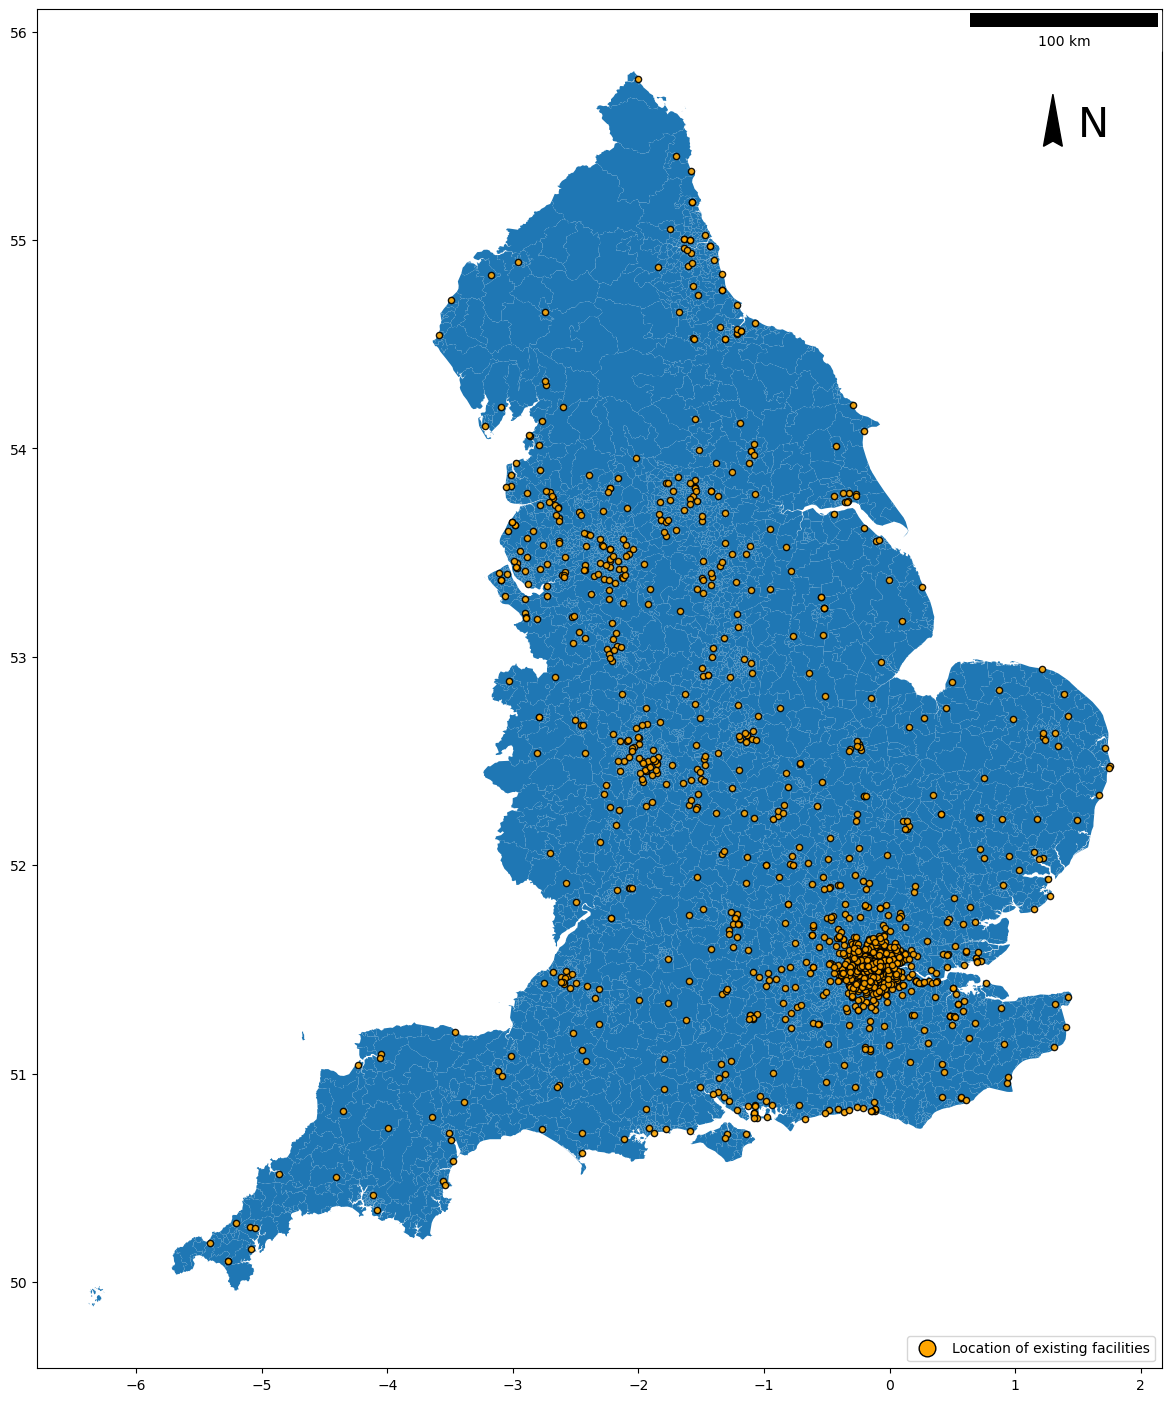

In [95]:
fig, ax = plt.subplots(figsize=(18,18),dpi=100)
legend_elements = []
#MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
gdf.plot(figsize = (18,18),ax=ax)

existing_points_gdf.plot(ax=ax,
                marker="o",
                markersize=20,
                alpha=0.9,
                zorder=4,
                edgecolor="k",
                facecolor='orange')
legend_elements.append(Line2D(
        [],
        [],
        color='orange',
        marker='o',
        markersize=12,
        markeredgecolor="k",
        linewidth=0,
        label='Location of existing facilities',
        ))

ax.text(x=1.5, y=55.5, s='N', fontsize=30)
ax.arrow(1.3, 55.5, 0, 0.20,length_includes_head=True,head_width=0.15, head_length=0.25, overhang=0.1, facecolor='k')

scalebar  = ScaleBar(66666.67,location='upper right')
plt.gca().add_artist(scalebar)

plt.legend(handles = legend_elements, loc='lower right')

In [76]:
print(ax.get_xticks())

[-7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.]


In [29]:
existing_points = pandas.read_csv('/Users/xrb/Desktop/Dissertation-on-Covid-19-vaccination-centres/Huanfa/df_existing_sites.csv')

In [31]:
existing_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1600 non-null   int64  
 1   index         1600 non-null   int64  
 2   supply_value  1600 non-null   int64  
 3   long          1600 non-null   float64
 4   lat           1600 non-null   float64
 5   site_ID       1600 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 75.1+ KB


In [32]:
existing_points_gdf = geopandas.GeoDataFrame(
    existing_points,
    geometry=geopandas.points_from_xy(
        existing_points.long, existing_points.lat
    ),
).sort_values(by=['index']).reset_index()

In [38]:
existing_points_gdf  = existing_points_gdf.set_crs('epsg:4326')

### 画优化后的图

#### 整理数据

In [138]:
best_solution = pandas.DataFrame(columns=['select'], index=range(num_facilities))

In [139]:
#把第一个solution存进dataframe里面
m_extended.setParam(GRB.Param.SolutionNumber, 0)
for j in range(num_facilities):
    best_solution.iloc[j,0] = select_extended[j].Xn

In [140]:
best_solution.head(15)

,select
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [141]:
#把之前存的site_ID从list转成dataframe
site_name = pandas.DataFrame(list_site_ID)

In [142]:
site_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22727 entries, 0 to 22726
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       22727 non-null  object
dtypes: object(1)
memory usage: 177.7+ KB


In [143]:
site_name = site_name.reset_index(drop=False)

In [144]:
#给solution连接上site_ID
best_solution = pandas.merge(left = best_solution, right=site_name,left_index=True, right_index=True)

In [145]:
best_solution.head(10)

,select,index,0
0,1.0,0,E0
1,0.0,1,E1
2,0.0,2,E10
3,0.0,3,E100
4,0.0,4,E1000
5,0.0,5,E1001
6,0.0,6,E1002
7,0.0,7,E1003
8,0.0,8,E1004
9,0.0,9,E1005


In [146]:
best_solution.rename(columns={0:'site_ID'},inplace=True)

In [147]:
#把现存设施和新设施分成两个dataframe，后续要连接点的空间信息
existing_solution = best_solution.iloc[:1600,:]
new_solution = best_solution.iloc[1600:,:]

In [148]:
existing_solution.head(5)

,select,index,site_ID
0,1.0,0,E0
1,0.0,1,E1
2,0.0,2,E10
3,0.0,3,E100
4,0.0,4,E1000


In [149]:
new_solution.head(5)

,select,index,site_ID
1600,0.0,1600,P0
1601,0.0,1601,P1
1602,0.0,1602,P10
1603,0.0,1603,P100
1604,0.0,1604,P1000


In [150]:
#把select为0，即没有被选中的点删掉
existing_solution = existing_solution.drop(existing_solution[existing_solution['select']<1].index)
new_solution = new_solution.drop(new_solution[new_solution['select']<1].index)

In [151]:
existing_solution.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 0 to 1574
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   select   107 non-null    object
 1   index    107 non-null    int64 
 2   site_ID  107 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.3+ KB


In [152]:
#给现存设施连接上空间信息
existing_solution = pandas.merge(left=existing_solution,right=existing_points,left_on='site_ID',right_on='site_ID')

In [153]:
existing_solution.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 0 to 106
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   select        107 non-null    object  
 1   index_x       107 non-null    int64   
 2   site_ID       107 non-null    object  
 3   Unnamed: 0    107 non-null    int64   
 4   index_y       107 non-null    int64   
 5   supply_value  107 non-null    int64   
 6   long          107 non-null    float64 
 7   lat           107 non-null    float64 
 8   geometry      107 non-null    geometry
dtypes: float64(2), geometry(1), int64(4), object(2)
memory usage: 8.4+ KB


In [155]:
#现存设施转换成geodataframe，完成做图准备
existing_solution_gdf = geopandas.GeoDataFrame(
    existing_solution,
    geometry=geopandas.points_from_xy(
        existing_solution.long, existing_solution.lat
    ),
)

existing_solution_gdf  = existing_solution_gdf.set_crs('epsg:4326')

In [158]:
poi = pandas.read_csv('/Users/xrb/Desktop/Dissertation-on-Covid-19-vaccination-centres/Huanfa/poi_three_types.csv')

In [159]:
poi['site_ID']=["P{}".format(ind) for ind in poi.index]
print("Number of POIs: {}".format(poi.shape[0]))
print("Columns: {}".format(poi.columns.values))

Number of POIs: 21812
Columns: ['name' 'feature_easting' 'feature_northing' 'pointx_class' 'site_ID']


In [172]:
from add_projected_XY import add_projected_XY

In [173]:
poi_sites = add_projected_XY(poi, col_y='feature_northing', col_x='feature_easting', new_col_x='long', new_col_y='lat', current_crs='epsg:27700', new_crs='epsg:4326')

In [175]:
poi_sites.head(5)

,name,feature_easting,feature_northing,pointx_class,site_ID,geometry,long,lat
0,Reiver House,338714.0,556014.0,5280365,P0,POINT (338714.000 556014.000),-2.957088,54.895084
1,Lloyds Pharmacy,430296.0,279574.0,5280364,P1,POINT (430296.000 279574.000),-1.556017,52.413332
2,Wilson Hospital,527876.0,168073.0,5280371,P2,POINT (527876.000 168073.000),-0.163246,51.397288
3,Elland Pharmacy,410903.0,421112.0,5280364,P3,POINT (410903.000 421112.000),-1.836388,53.686351
4,Pimhole Pharmacy,381373.0,410753.0,5280364,P4,POINT (381373.000 410753.000),-2.282894,53.593018


In [176]:
#给新设施连接上poi空间信息
new_solution = pandas.merge(left=new_solution,right=poi_sites,left_on='site_ID',right_on='site_ID')

In [177]:
#新设施转换成geodataframe，完成做图准备
new_solution_gdf = geopandas.GeoDataFrame(
    new_solution,
    geometry=geopandas.points_from_xy(
        new_solution.long, new_solution.lat
    ),
)

new_solution_gdf  = new_solution_gdf.set_crs('epsg:4326')

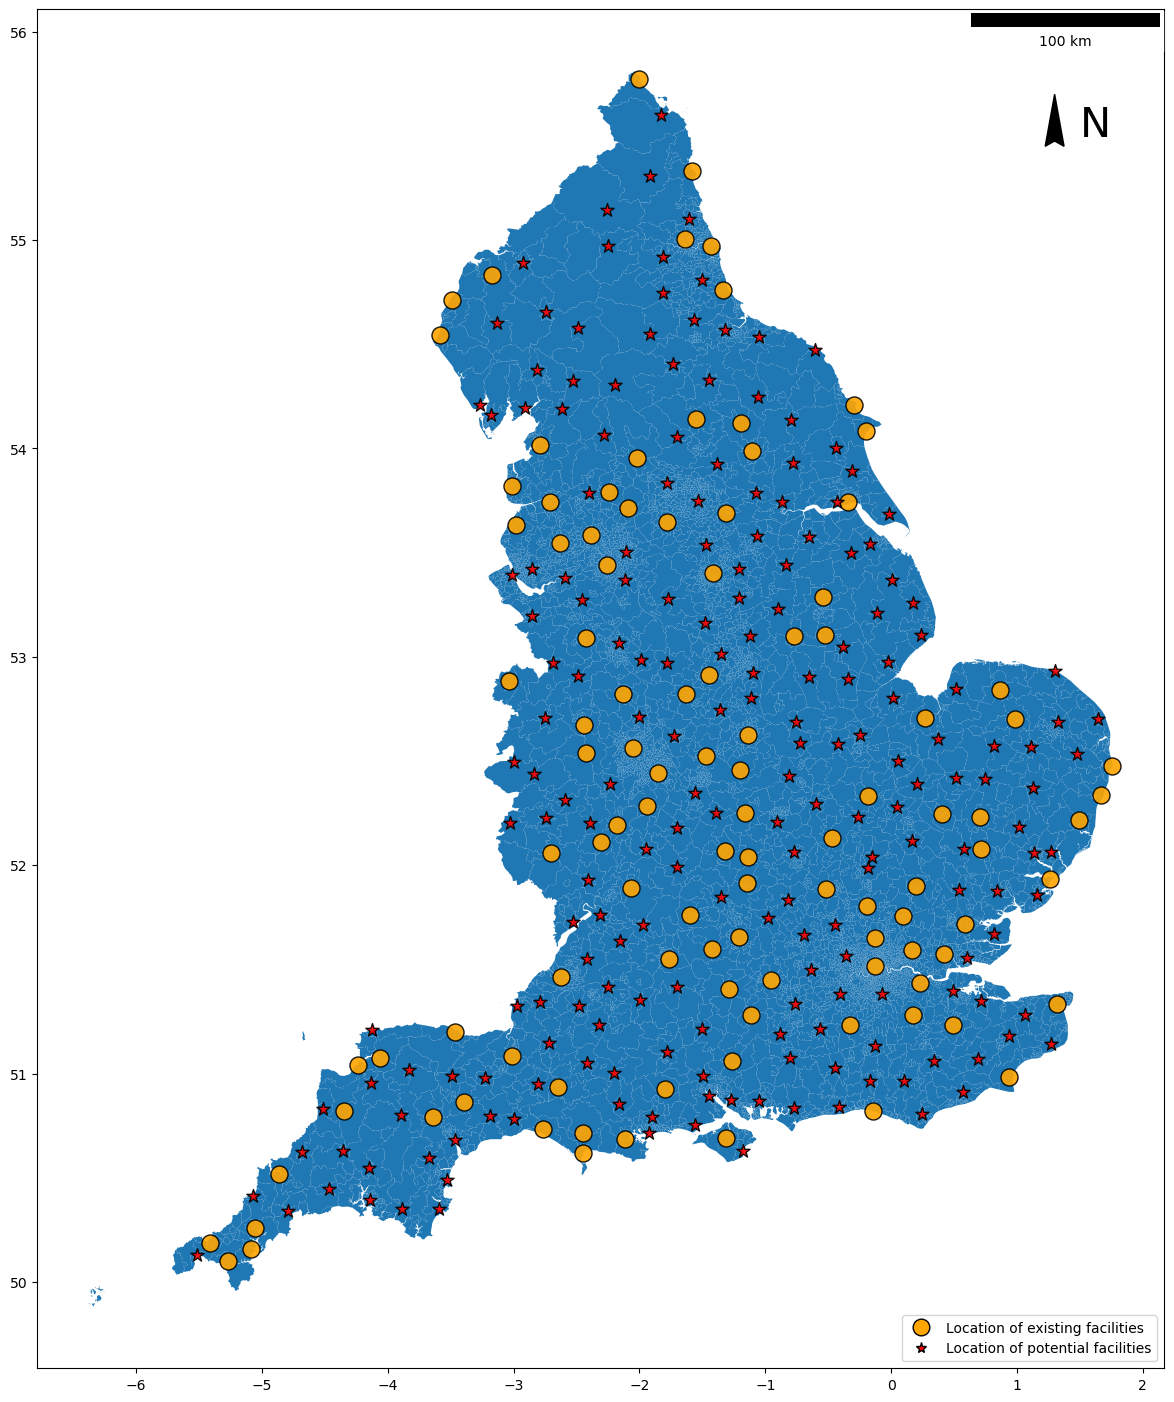

In [189]:
fig, ax = plt.subplots(figsize=(18,18),dpi=100)
legend_elements = []
#MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
gdf.plot(figsize = (18,18),ax=ax)

#现存设施：圆圈
existing_solution_gdf.plot(ax=ax,
                marker="o",
                markersize=150,
                alpha=0.9,
                zorder=4,
                edgecolor="k",
                facecolor='orange')
legend_elements.append(Line2D(
        [],
        [],
        color='orange',
        marker='o',
        markersize=12,
        markeredgecolor="k",
        linewidth=0,
        label='Location of existing facilities',
        ))
#新设施：五角星
new_solution_gdf.plot(ax=ax,
                marker="*",
                markersize=100,
                alpha=0.9,
                zorder=4,
                edgecolor="k",
                facecolor='red')
legend_elements.append(Line2D(
        [],
        [],
        color='red',
        marker='*',
        markersize=8,
        markeredgecolor="k",
        linewidth=0,
        label='Location of potential facilities',
        ))

ax.text(x=1.5, y=55.5, s='N', fontsize=30)
ax.arrow(1.3, 55.5, 0, 0.20,length_includes_head=True,head_width=0.15, head_length=0.25, overhang=0.1, facecolor='k')

scalebar  = ScaleBar(66666.67,location='upper right')
plt.gca().add_artist(scalebar)

plt.legend(handles = legend_elements, loc='lower right')